In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
import random 
from datetime import datetime
from sklearn.preprocessing import StandardScaler

def print_data_summary(data):
    print("There are {0} datapoints".format(len(data)))
    print("There are {0} columns".format(len(data.columns)))
    try:
        print("There are {0} diffenret movies".format(len(set(data['s_video_id']))))
    except:
        pass
    # print(data.describe())
    
def encode_one_hot(data):
    categorical_columns = get_categorical_columns(data)
    oneHotEncodedData = pd.get_dummies(data, columns=categorical_columns)
    
    # Test
    newNumberOfColumns = len(oneHotEncodedData.columns) 

    totalDifferentValues = 0
    for c in categorical_columns:
        totalDifferentValues += len(data[c].unique())

    # One hot encoding removes each categorical columns (- len(nonNumericalList)) 
    # and adds n columns where n is number of different values taken by column (+ totalDifferentValues)
    assert len(data.columns) + totalDifferentValues - len(categorical_columns) == newNumberOfColumns
    
    return oneHotEncodedData

def split_train_test(data, test_mask):
    # split between train and test
    train_mask = list(map(lambda b: not b, test_mask))

    train = data[train_mask]
    test = data[test_mask]

    assert len(train) + len(test) == len(data) 

    y_train = train.loc[:, ['t_average_vmaf']]
    x_train = train.drop(['t_average_vmaf'], axis=1)
    assert type(x_train) == type(y_train) 

    y_test = test.loc[:, ['t_average_vmaf']]
    x_test = test.drop(['t_average_vmaf'], axis=1)
    assert type(x_test) == type(y_test)

    assert len(x_train) == len(y_train)
    assert len(x_train.columns) + len(y_train.columns) == len(data.columns)
    assert len(x_test) == len(y_test)
    assert len(x_test.columns) + len(y_test.columns) == len(data.columns)
    return x_train, y_train, x_test, y_test

def calculate_rmse(y_true, y_predictions):
    mse = mean_squared_error(y_true, y_predictions)
    rmse = math.sqrt(mse)
    return rmse

def calculate_std(y_true, y_predictions):
    '''
    Standard deviation is calculated considering the absoulte values of the residuals as the
    values and the RMSE as the mean.
    '''
    rmse = calculate_rmse(y_true, y_predictions)
    
    abs_residuals = np.absolute(y_true - y_predictions)
    
    
    #print(abs_residuals)
    #print(abs_residuals.tolist().sort(reverse=True))
    tbp = list(np.ravel(abs_residuals))
    tbp.sort(reverse=True)
    print("Printing the 4th quartile to doublecheck std: ")
    print(np.percentile(tbp, 75))  # Q3
    #print(tbp[0:20])

    
    rmse_column = np.array([rmse]*len(abs_residuals)).reshape(len(abs_residuals), 1)

    #print("len(abs_residuals)")
    #print(len(abs_residuals))
    #print("rmse_column")
    #print(rmse_column)
    variance = np.sum(np.square(abs_residuals - rmse_column)) / len(abs_residuals)
    std = math.sqrt(variance)
    return std

def run_model(regression_model, x_train, y_train, x_test, y_test):
    '''
    Given a sklearn model and the train / test data,
    returns the rmse, std and r squared scores of the model
    also returns training time in seconds
    '''
    start_time = datetime.now().timestamp()
   
    regular_regression = regression_model.fit(x_train.to_numpy(), y_train.to_numpy())

    end_time = datetime.now().timestamp()
   
    predictions = regression_model.predict(x_test.to_numpy())

    rmse = calculate_rmse(y_test.to_numpy(), predictions)

    std = calculate_std(y_test.to_numpy(), predictions)

    coefficient_of_determination = regression_model.score(x_test.to_numpy(), y_test.to_numpy())
    
    return Model_results(rmse, std, coefficient_of_determination, end_time - start_time, regression_model)

def analyse_model(regression_model, x_train, y_train, x_test, y_test):
    regular_regression = regression_model.fit(x_train.to_numpy(), y_train.to_numpy())
    
    paramRelevance = {'Parameter':x_train.columns.to_list()[:],
            'Weight':regular_regression.coef_.tolist()[0]}
 
    dfParam = pd.DataFrame(paramRelevance)

    print(dfParam.sort_values(by='Weight', ascending=False)[:])

class Model_results:
    def __init__(self, rmse, std, cod, time, model):
        self.rmse = rmse
        self.std = std
        self.cod = cod
        self.time = time
        self.model = model
        
    def __str__(self):
        attrs = vars(self)
        return ', '.join("%s: %s" % item for item in attrs.items())
    
def get_numerical_columns(data):
    numerical = data.select_dtypes(exclude=['object'])
    exclude_categorical = [col for col in numerical.columns \
                                   if not 'content_category' in col \
                                   and not 'scan_type' in col \
                                   and not 'codec_profile' in col \
                                   and not 's_video_id' in col]
    return exclude_categorical

def get_categorical_columns(data):
    numerical_columns = set(get_numerical_columns(data))
    return set(data.columns) - numerical_columns

def explore_categorical_features(data):
    # explorig categorical columns
    nonNumericalFrame = data.select_dtypes(include=['object']).copy()
    nonNumericalList = nonNumericalFrame.columns.tolist()
    totalDifferentValues = 0
    for c in nonNumericalList:
        print("{0} is non-numerical and values are: {1}".format(c, nonNumericalFrame[c].unique()))
        totalDifferentValues += len(nonNumericalFrame[c].unique())

    print("There are {0} total possible values among the categorical columns".format(totalDifferentValues))

    # content_category is the most problematic column because it has many possible values
    # nonNumericalFrame["c_content_category"].value_counts()

In [3]:
data = pd.read_csv("data.csv")
rawColumns = data.columns
rawData = deepcopy(data)

# test 
assert len(get_numerical_columns(data)) + len(get_categorical_columns(data)) == len(data.columns)

In [4]:
# PREPROCESSING

# 1 Remove empty columns
data = data.dropna(axis=1, thresh=len(data.columns))
print("The following columns have been removed because empty: {0}".format(set(rawColumns) - set(data.columns)))

# 2 Remove rows with missing values
threshold = len(data.columns)
data = data.dropna(axis=0, thresh=threshold)
print("There were {0} rows deleted because they had less than {1} valorised features".format(len(rawData) - len(data), threshold))

# 3 Remove columns that always have the same value
nunique = data.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
data = data.drop(cols_to_drop, axis=1)
for c in cols_to_drop.tolist():
    print("Column {0} always has same value: {1}, removed".format(c, rawData[c].tolist()[1]))
assert len(nunique) == len(data.columns) + len(cols_to_drop)

# 4 Remove video id
data = data.drop(['s_video_id'], axis = 1)

print("\nAfter inital processing")
print_data_summary(data)

# 5 Coalesce width and height to a categorical feature
# print(data.groupby(['s_width','s_height']).size().reset_index().rename(columns={0:'count'}))

data['s_size'] = data.apply(lambda row: str(row['s_width']) + "_" + str(row['s_height']), axis=1)
data = data.drop(['s_width', 's_height'], axis = 1)

# 6 convert size to 

# explore_categorical_features(data)

# 6 Scale data (mean is zero)

# split data in numerical, categorical, y columns
y = data['t_average_vmaf']
categorical = data[get_categorical_columns(data.drop(['t_average_vmaf'], axis = 1))]
numerical = data[get_numerical_columns(data.drop(['t_average_vmaf'], axis = 1))]

# scale only numerical
scaler = StandardScaler()
scaler.fit(numerical)
scaled_numerical = scaler.transform(numerical)

# recombine everything
numerical_data = pd.DataFrame(scaled_numerical, numerical.index, columns=numerical.columns)
# test
assert len(numerical_data.columns) + len(categorical.columns) + 1 == len(data.columns)
data = pd.concat([numerical_data, categorical, y], axis=1)

print("\nAfter scaling")
print_data_summary(data)

# 5 One hot encoding categorical columns

# pro wrt label encoding: the model wont derive false relations between columns based on numerical values (2 > 1)
# con wrt label encoding: more columns are introduced

data = encode_one_hot(data)
print("\nAfter 1 hot encoding categorical features")
print_data_summary(data)


preprocessed_data = deepcopy(data)

preprocessed_data.head()

The following columns have been removed because empty: {'t_average_vmaf_mobile', 't_average_vmaf_4k', 't_average_psnr'}
There were 2883 rows deleted because they had less than 43 valorised features
Column e_aspect_ratio always has same value: 16:09, removed
Column e_pixel_aspect_ratio always has same value: 1:01, removed
Column e_codec always has same value: h264, removed
Column e_b_frame_int always has same value: 3, removed
Column e_ref_frame_count always has same value: 1.0, removed
Column e_bit_depth always has same value: 8.0, removed
Column e_pixel_fmt always has same value: yuv420p, removed

After inital processing
There are 12133 datapoints
There are 35 columns

After scaling
There are 12133 datapoints
There are 34 columns

After 1 hot encoding categorical features
There are 12133 datapoints
There are 110 columns


,s_storage_size,s_duration,c_si,c_ti,c_scene_change_ffmpeg_ratio30,c_scene_change_ffmpeg_ratio60,c_scene_change_ffmpeg_ratio90,c_scene_change_py_thresh30,c_scene_change_py_thresh50,c_colorhistogram_mean_dark,...,e_codec_profile_high,e_codec_profile_main,s_size_1080_1080,s_size_1280_720,s_size_1920_1080,s_size_1920_800,s_size_1920_818,s_size_352_288,s_size_720_486,s_size_720_608
0,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,1,0,0,0,1,0,0,0,0,0
1,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,0,1,0,0,1,0,0,0,0,0
2,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,0,1,0,0,1,0,0,0,0,0
3,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,0,1,0,0,1,0,0,0,0,0
4,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,0,1,0,0,1,0,0,0,0,0


In [5]:
# Data augmentation

# from [x, y, z] we want to obtain 
# [x, y, z, x**2, y**2, z**2, x*y, x*z, y*z]
# aka all the degree 2 polinomyals 

# only consider numerical columns, exluce categorical

exclude_categorical = get_numerical_columns(preprocessed_data)

theoretical_final_number_of_columns = len(data.columns) + \
+ len(exclude_categorical) + \
((len(exclude_categorical)) * (len(exclude_categorical) - 1)) / 2

baseForAugmentation = data[exclude_categorical]

columnsCopy = baseForAugmentation.columns.tolist()

print("original oclumns {0}".format(len(baseForAugmentation.columns)))

for c in baseForAugmentation.columns:

    data[c + "_squared"] = data[c] ** 2
    data[c + "cubic"] = data[c] ** 3
    
    columnsCopy.remove(c)
    for cc in columnsCopy:
        t = data[c] * data[cc]
        data[c + "_*_" + cc ] = data[c] * data[cc]

# assert(int(theoretical_final_number_of_columns) == len(data.columns.tolist()))

print("After augmenting the data")
print_data_summary(data)
augmented_data = deepcopy(data)
augmented_data.head()

original oclumns 37
After augmenting the data
There are 12133 datapoints
There are 850 columns


,s_storage_size,s_duration,c_si,c_ti,c_scene_change_ffmpeg_ratio30,c_scene_change_ffmpeg_ratio60,c_scene_change_ffmpeg_ratio90,c_scene_change_py_thresh30,c_scene_change_py_thresh50,c_colorhistogram_mean_dark,...,s_size_1920_818_*_s_size_720_608,s_size_352_288_squared,s_size_352_288cubic,s_size_352_288_*_s_size_720_486,s_size_352_288_*_s_size_720_608,s_size_720_486_squared,s_size_720_486cubic,s_size_720_486_*_s_size_720_608,s_size_720_608_squared,s_size_720_608cubic
0,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,0,0,0,0,0,0,0,0,0,0
1,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,0,0,0,0,0,0,0,0,0,0
2,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,0,0,0,0,0,0,0,0,0,0
3,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,0,0,0,0,0,0,0,0,0,0
4,-0.49794,-0.598653,0.653567,-0.41539,-0.239026,-0.74125,-0.512497,-1.518056,-1.161942,-0.214322,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# PCA
from sklearn.decomposition import PCA
import math

# for PCA to work well data needs to be scaled (mean is zero)
scaler = StandardScaler()
scaler.fit(augmented_data.drop(['t_average_vmaf'], axis=1))
scaledData = scaler.transform(augmented_data.drop(['t_average_vmaf'], axis=1))

# reducing the data to an arbitrary number of dimensions
pca = PCA(n_components=5)
pca.fit(scaledData)
pca_data = pca.transform(scaledData)

# Principal components are new variables that are constructed 
# as linear combinations or mixtures of the initial variables.
# We don't have the original headers names

pca_data = pd.DataFrame(data=pca_data)

if not pca_data.index.equals(augmented_data.index):
    pca_data.index = augmented_data.index
    
# adding the y back
# it was removed because otherwise it would have been lost in the pca process
pca_data['t_average_vmaf'] = augmented_data['t_average_vmaf']

print("After applying PCA to the data")
print_data_summary(pca_data)

After applying PCA to the data
There are 12133 datapoints
There are 6 columns


In [7]:
# Splitthe 3 datasets (preprocessed, augmented, PCAed)
# Note the the same splitting is applied across all 3 

test_mask = np.random.rand(len(data), 1) > 0.60

x_train_pre, y_train_pre, x_test_pre, y_test_pre = split_train_test(preprocessed_data, test_mask)
x_train_aug, y_train_aug, x_test_aug, y_test_aug = split_train_test(augmented_data, test_mask)
x_train_pca, y_train_pca, x_test_pca, y_test_pca = split_train_test(pca_data, test_mask)

In [8]:
# Regressions

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math


analyse_model(LinearRegression(), x_train_pre, y_train_pre, x_test_pre, y_test_pre)
if True:
    # regular
    print("Regular regression")
    print(run_model(LinearRegression(), x_train_pre, y_train_pre, x_test_pre, y_test_pre))
    print(run_model(LinearRegression(), x_train_aug, y_train_aug, x_test_aug, y_test_aug))
    print(run_model(LinearRegression(), x_train_pca, y_train_pca, x_test_pca, y_test_pca))

    # lasso (coefficients tend to zero)
    from sklearn.linear_model import Lasso
    print("\nLasso regression")
    print(run_model(Lasso(alpha=0.8), x_train_pre, y_train_pre, x_test_pre, y_test_pre))
    print(run_model(Lasso(alpha=0.8), x_train_aug, y_train_aug, x_test_aug, y_test_aug))
    print(run_model(Lasso(alpha=0.8), x_train_pca, y_train_pca, x_test_pca, y_test_pca))

    # ridge 
    from sklearn.linear_model import Ridge
    print("\nRidge regression")
    print(run_model(Ridge(alpha=0.9), x_train_pre, y_train_pre, x_test_pre, y_test_pre))
    print(run_model(Ridge(alpha=0.9), x_train_aug, y_train_aug, x_test_aug, y_test_aug))
    print(run_model(Ridge(alpha=0.9), x_train_pca, y_train_pca, x_test_pca, y_test_pca))

                        Parameter        Weight
28         s_scan_type_interlaced  2.364968e+12
29        s_scan_type_progressive  2.364968e+12
23                       e_height  1.019149e+12
26                     e_gop_size  8.588038e+11
53    c_content_category_fountain  2.162891e+11
..                            ...           ...
25                    e_framerate -8.588038e+11
22                        e_width -1.019149e+12
98        e_scan_type_progressive -1.402630e+12
97  e_scan_type_not supported yet -1.402630e+12
96         e_scan_type_interlaced -1.402630e+12

[109 rows x 2 columns]
Regular regression
Printing the 4th quartile to doublecheck std: 
7.65900634765625
rmse: 7.285720740834151, std: 4.919918603616527, cod: 0.9453210787162668, time: 0.011597156524658203, model: LinearRegression()
Printing the 4th quartile to doublecheck std: 
1.0551942652980983e-10
rmse: 9.594905900137562e-11, std: 6.489149746727142e-11, cod: 1.0, time: 0.22246289253234863, model: LinearRegression()

/Users/carlo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25749.495583868622, tolerance: 710.747700993931
  model = cd_fast.enet_coordinate_descent(


Printing the 4th quartile to doublecheck std: 
56.346526856221914
rmse: 1.9430468132929464, std: 2956.0345638116487, cod: 0.99611096882497, time: 2.6351962089538574, model: Lasso(alpha=0.8)
Printing the 4th quartile to doublecheck std: 
39.744292013832236
rmse: 31.143723037090805, std: 1046.0497287254518, cod: 0.0008839089959106206, time: 0.0019078254699707031, model: Lasso(alpha=0.8)

Ridge regression
Printing the 4th quartile to doublecheck std: 
7.648814198930364
rmse: 7.284135925078364, std: 4.91968193881526, cod: 0.9453448640339259, time: 0.030031919479370117, model: Ridge(alpha=0.9)
Printing the 4th quartile to doublecheck std: 
0.0017219898147704527
rmse: 0.0016566558302062457, std: 0.0011708823751943765, cod: 0.999999997172911, time: 0.09944391250610352, model: Ridge(alpha=0.9)
Printing the 4th quartile to doublecheck std: 
39.68327998367068
rmse: 31.141545087227655, std: 15.01484960519927, cod: 0.0010236449333226316, time: 0.0018191337585449219, model: Ridge(alpha=0.9)


In [9]:
# Random Forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('once')

# max_features is optimum at 41, but could be less to improve time and lose some score.
rf_model_pre = RandomForestRegressor(
            n_estimators = 25,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 41,
            oob_score    = True,
            n_jobs       = -1,
            random_state = 123
         )
# max_features is optimum at 300+ but 75 seems reasonable, yet it could be less to improve time and lose some score.
rf_model_aug = RandomForestRegressor(
            n_estimators = 25,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 75,
            oob_score    = True,
            n_jobs       = -1,
            random_state = 123
         )
# max_features is optimum at 5 and it cannot be higher than that. Increasing n_estimators doesn't help much.
rf_model_pca = RandomForestRegressor(
            n_estimators = 25,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 5,
            oob_score    = True,
            n_jobs       = -1,
            random_state = 123
         )
print(run_model(rf_model_pre, x_train_pre, y_train_pre, x_test_pre, y_test_pre))
print(run_model(rf_model_aug, x_train_aug, y_train_aug, x_test_aug, y_test_aug))
print(run_model(rf_model_pca, x_train_pca, y_train_pca, x_test_pca, y_test_pca))

<ipython-input-2-d42522d5e597>:100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regular_regression = regression_model.fit(x_train.to_numpy(), y_train.to_numpy())


Printing the 4th quartile to doublecheck std: 
55.45619019
rmse: 2.7067105709255226, std: 2901.6747824046297, cod: 0.9924532748299972, time: 0.2295091152191162, model: RandomForestRegressor(max_features=41, n_estimators=25, n_jobs=-1,
                      oob_score=True, random_state=123)


<ipython-input-2-d42522d5e597>:100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regular_regression = regression_model.fit(x_train.to_numpy(), y_train.to_numpy())


Printing the 4th quartile to doublecheck std: 
55.680536119999985
rmse: 0.5469057660220302, std: 3034.819147967697, cod: 0.9996918941809407, time: 0.7032389640808105, model: RandomForestRegressor(max_features=75, n_estimators=25, n_jobs=-1,
                      oob_score=True, random_state=123)


<ipython-input-2-d42522d5e597>:100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regular_regression = regression_model.fit(x_train.to_numpy(), y_train.to_numpy())


Printing the 4th quartile to doublecheck std: 
53.855534719999994
rmse: 7.2104034294750905, std: 2578.097835133889, cod: 0.9464457396382586, time: 0.11253595352172852, model: RandomForestRegressor(max_features=5, n_estimators=25, n_jobs=-1,
                      oob_score=True, random_state=123)


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import plot_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle

# single layer perceptron model in keras
# input is the number of columns
# there is one fully connected layer with 128 nodes, 128 is arbitrary 
# output is one float
def make_nn1_closure(firstLayerNodes, dropOutPercentage, optimiser, activation, input_dim):
    def make_nn1():
        model = Sequential()
        model.add(Dense(firstLayerNodes, activation=activation, input_dim=input_dim))
        model.add(Dropout(dropOutPercentage))
        model.add(Dense(1, kernel_initializer='normal'))
        # plot_model(model, show_shapes=True, rankdir="LR")
        model.compile(loss='mean_squared_error', optimizer=optimiser)
        return model
    return make_nn1

def make_nn2_closure(firstLayerNodes, secondLayerNodes, dropOutPercentage, optimiser, activation, input_dim):
    def make_nn2():
        model = Sequential()
        model.add(Dense(firstLayerNodes, activation=activation, input_dim=input_dim))
        model.add(Dropout(dropOutPercentage))
        model.add(Dense(secondLayerNodes, activation=activation))
        model.add(Dense(1, kernel_initializer='normal'))
        # plot_model(model, show_shapes=True, rankdir="LR")
        model.compile(loss='mean_squared_error', optimizer=optimiser)
        return model
    return make_nn2

class Params:
        
        def __init__(self, first_nodes, second_nodes, epochs, kfold, opti, acti, drop, batch_size):
            self.first_nodes = first_nodes
            self.second_nodes = second_nodes
            self.epochs = epochs
            self.kfold = kfold
            self.optimizer = opti
            self.activation = acti
            self.drop = drop
            self.batch_size = batch_size
            
        def __str__(self):
            attrs = vars(self)
            return ', '.join("%s: %s" % item for item in attrs.items())

class Grid_parameters:
    nodeValues = list(range(5, 50))
    batchValues = [2, 4, 8, 16, 32]
    epochesValues = [2]#list(range(35, 75, 10))
    kFoldSplitValues = [10, 5, 12]
    optimizers = ["RMSprop", "adam", "Adadelta", "Nadam"]
    activations=["softmax", "relu", "tanh"]
    dropOuts = list(np.arange(0.0, 0.8, 0.05))
    
    def __init__(self):
        pass
    
    def get_random_params(self):
        return Params(random.choice(self.nodeValues), 
                      random.choice(self.nodeValues),
                      random.choice(self.epochesValues),
                      random.choice(self.kFoldSplitValues),
                      random.choice(self.optimizers),
                      random.choice(self.activations),
                      random.choice(self.dropOuts),
                      random.choice(self.batchValues)
                     )

ModuleNotFoundError: No module named 'keras'

In [ ]:
# cross validating the model doesnt fit it, i.e. cannot be used to predict
# need to regualrly fit it using all the training data
# cv usefull for selecting the model topology

# PICKLE READ FILE

#infile = open('results_pre','rb')
#new_dict = pickle.load(infile)
#print(new_dict[0][0])
#infile.close()

grid = Grid_parameters()

results_pre = []
results_aug = []
results_pca = []

for i in range(0, 20):
    params = grid.get_random_params()
    print(params)
    
    estimators_1 = []
    estimators_2 = []
    estimators_1.append(('standardize', StandardScaler()))
    estimators_2.append(('standardize', StandardScaler()))
    
    model_1 = make_nn1_closure(params.first_nodes, params.drop, params.optimizer, params.activation, x_train_pre.shape[1])
    model_2 = make_nn2_closure(params.first_nodes, params.second_nodes, params.drop, params.optimizer, params.activation, x_train_pre.shape[1])
    
    estimators_1.append(('mlp', KerasRegressor(build_fn=model_1, 
                                             epochs=params.epochs, 
                                             batch_size=params.batch_size, 
                                             verbose=1)))
    estimators_2.append(('mlp', KerasRegressor(build_fn=model_2, 
                                             epochs=params.epochs, 
                                             batch_size=params.batch_size, 
                                             verbose=1)))
    
    pipeline_1 = Pipeline(estimators_1)
    pipeline_1 = Pipeline(estimators_2)
    
    kfold = KFold(n_splits=params.kfold)
    
    result_pre_1 = cross_val_score(pipeline_1, x_train_pre.to_numpy(), y_train_pre.to_numpy(), cv=kfold)
    result_pre_2 = cross_val_score(pipeline_2, x_train_pre.to_numpy(), y_train_pre.to_numpy(), cv=kfold)
    #result_aug = cross_val_score(pipeline, x_train_pre.to_numpy(), y_train_pre.to_numpy(), cv=kfold)
    #result_pca = cross_val_score(pipeline, x_train_pre.to_numpy(), y_train_pre.to_numpy(), cv=kfold)
    
    print("Standardized: mean is %.2f, std is %.2f" % (result_pre.mean(), result_pre.std()))
    #print("Standardized: mean is %.2f, std is %.2f" % (result_aug.mean(), result_aug.std()))
    #print("Standardized: mean is %.2f, std is %.2f" % (result_pca.mean(), result_pca.std()))
    
    results_pre.append((params, result_pre))
    #results_aug.append((params, result_aug))
    #results_pca.append((params, result_pca))
    
    with open('results_pre', 'wb') as save:
        pickle.dump(results_pre, save)
    
    
    
# below I copied pased the best results 

# No Dropout
# Standardized: mean is -46.98, std is 18.11
            # running model with 29 firstLayerNodes, 8 secondLayerNodes,           
            # 40 epochs, 10 batchSize, 10 k_fold_split

# Standardized: mean is -48.66, std is 18.17
            # running model with 29 firstLayerNodes, 44 secondLayerNodes,           
            # 40 epochs, 5 batchSize, 5 k_fold_split

# Standardized: mean is -51.15, std is 14.19, 
            # running model with 6 firstLayerNodes, 50 secondLayerNodes, 
            # 30 epochs, 20 batchSize, 10 k_fold_split
        
# Dropout after first dense layer


In [ ]:
# We see that content_category features have high scores on average.
# Unfortunately there are many content_categories and often 
# there is only one representative movie for each one.
# This means that is a powerful feature but it doesnt generalize.
# (e.g. security example: if I see a man with a gun is 100% dangerous but it's rare that such obvious feature
# will be observed; many men are dangerous without showing a gun)

categoriesWithHighWeight = ["c_content_category_croquet ball", 
                            "c_content_category_bathing cap", 
                            "c_content_category_dumbbell",
                           "c_content_category_envelope",
                           "c_content_category_palace"]
for cat in categoriesWithHighWeight:
    howManyRowsHaveTheCategory = sum(data[cat].tolist())
    print("There are {0} raws with category {1}".format(howManyRowsHaveTheCategory, cat))
    categoryIndexer = (data[cat] == 1).tolist()
    videoIdsCorrespondingToCategory = data["s_video_id"][categoryIndexer]
    boolean_array_are_some_ids_different_from_first = videoIdsCorrespondingToCategory != videoIdsCorrespondingToCategory.tolist()[0]
    at_least_two_ids_are_different = any(boolean_array_are_some_ids_different_from_first.tolist())
    if at_least_two_ids_are_different:
        print("{0} is found on more than one movie\n".format(cat))
    else :
        print("{0} is found on EXACTLY one movie\n".format(cat))

In [ ]:
# Now the parameters closest to 0
epsilon = 0.1
dfParam[((regular_regression.coef_ < epsilon) & (regular_regression.coef_ > -epsilon)).tolist()[0]].sort_values(by='Weight', ascending=False)

# TODO remove e_scan_type_not supported yet? what does this column actually mean?

In [ ]:
# visualize the relationship between most relevant parameters and t_average_vmaf using scatterplots
import seaborn as sns

fig, axs = plt.subplots(ncols=4)
fig.set_size_inches(18.5, 10.5)
sns.regplot(x='c_content_category_croquet ball', y='t_average_vmaf', data=data, ax=axs[0])
sns.regplot(x='c_colorhistogram_std_dev_medium_bright', y='t_average_vmaf', data=data, ax=axs[1])
sns.regplot(x='c_content_category_bathing cap',y='t_average_vmaf', data=data, ax=axs[2])
sns.regplot(x='c_colorhistogram_mean_bright',y='t_average_vmaf', data=data, ax=axs[3])
plt.show()

# Nothing useful.... I don't delete it in case we can use this tool in the future for demo

In [ ]:
# Check the correlation of the 2 most relevant (positive and negative) non-categorical variables

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(18.5, 10.5)
sns.regplot(x='c_colorhistogram_std_dev_medium_bright', y='c_colorhistogram_mean_bright', data=data, ax=axs[0]) #Positive
sns.regplot(x='c_colorhistogram_std_dev_medium_dark', y='c_colorhistogram_mean_medium_bright', data=data, ax=axs[1]) #Negative
plt.show()

# Nothing useful... I don't delete it in case we can use this tool in the future for demo

In [ ]:
# We repeat the regular regression but we remove the content_category from the taining data
# Purpose
# 1: experiment and see how model performs without such scattered information
# 2: force the model to give importance to features that generalise
from sklearn.linear_model import LinearRegression

columns_except_content_category = [col for col in x_train.columns if not 'content_category' in col]

regular_regression2 = LinearRegression().fit(x_train[columns_except_content_category].to_numpy(), y_train.to_numpy())
coefficient_of_determination2 = regular_regression2.score(x_test[columns_except_content_category].to_numpy(), y_test.to_numpy())
print("Coefficient of determination on unseen test data {0}".format(coefficient_of_determination2))

predictions2 = regular_regression2.predict(x_test[columns_except_content_category].to_numpy())
mse2 = mean_squared_error(y_test, predictions2)
print("MSE on test {0}".format(mse2))

In [ ]:
# Importance of predictors by purity of nodes
# ==============================================================================
predictors_importance = pd.DataFrame(
                            {'predictor': data.drop(columns = "t_average_vmaf").columns,
                             'importance': RFmodel.feature_importances_}
                            )
print("importance of predictors")
print("-------------------------------------------")
predictors_importance.sort_values('importance', ascending=False)

# TODO: why is height & width so important for this model but it wasnt at all in linear regression?

In [ ]:
# Importance of predictors by permutation
# ==============================================================================
from sklearn.inspection import permutation_importance
import multiprocessing

importance = permutation_importance(
                estimator    = RFmodel,
                X            = x_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Store results (mean and stddev) in a dataframe
df_importance = pd.DataFrame(
                    {k: importance[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = x_train.columns
df_importance.sort_values('importances_mean', ascending=False)

In [ ]:
# Graph

# we can see how the content_categories feature have very little importance.
# This is expected since creating a 'split' on a feture that is valorised only for
# a small number of datapoints is against the criteria of how random forest works

fig, ax = plt.subplots(figsize=(5, 18))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of predictors (train)')
ax.set_xlabel('Error increase after permutation');

Max score: 0.9440248985901017


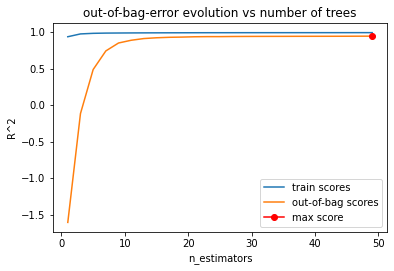

In [13]:
if 1 == 0:  # Skip it, this cell is used only to obtain the optimum value of n_estimators through out-of-bag error
    warnings.simplefilter("ignore")
    # Validation using Out-of-Bag error
    # ==============================================================================
    train_scores = []
    oob_scores   = []
    iter_x_train = x_train_pca
    iter_y_train = y_train_pca

    # Evaluated values
    estimator_range = range(1, 50, 2)

    # Loop to train model with each n_estimators value and obtain its training and OOB error
    for n_estimators in estimator_range:
        RFmodel = RandomForestRegressor(
                    n_estimators = n_estimators,
                    criterion    = 'mse',
                    max_depth    = None,
                    max_features = 'auto',
                    oob_score    = True,
                    n_jobs       = -1,
                    random_state = 123
                 )
        RFmodel.fit(iter_x_train, iter_y_train)
        train_scores.append(RFmodel.score(iter_x_train, iter_y_train))
        oob_scores.append(RFmodel.oob_score_)

    # Graph with the error trend
    fig, ax = plt.subplots(figsize=(6, 3.84))
    ax.plot(estimator_range, train_scores, label="train scores")
    ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
    ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
            marker='o', color = "red", label="max score")
    ax.set_ylabel("R^2")
    ax.set_xlabel("n_estimators")
    ax.set_title("out-of-bag-error evolution vs number of trees")
    plt.legend();
    print(f"Max score: {max(oob_scores)}");

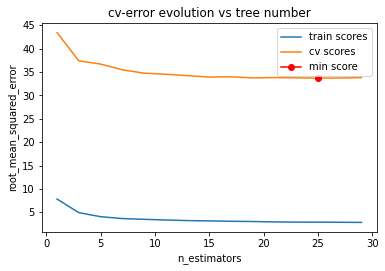

In [16]:
if 0 == 1:  # Skip it, this cell is used only to obtain the optimum value of n_estimators through k-cross-validation and neg_root_mean_squared_error
    warnings.simplefilter("ignore")
    # Validation using k-cross-validation and neg_root_mean_squared_error
    # ==============================================================================
    from sklearn.model_selection import cross_val_score

    train_scores = []
    cv_scores    = []
    iter_x_train = x_train_pca
    iter_y_train = y_train_pca

    # Evaluated values
    estimator_range = range(1, 30, 2)

    # Loop to train a model with each n_estimators value and obtain its training and
    # k-cross-validation error.
    for n_estimators in estimator_range:

        RFmodel = RandomForestRegressor(
                    n_estimators = n_estimators,
                    criterion    = 'mse',
                    max_depth    = None,
                    max_features = 'auto',
                    oob_score    = False,
                    n_jobs       = -1,
                    random_state = 123
                 )

        # Train error
        RFmodel.fit(iter_x_train, iter_y_train)
        RFpredictions = RFmodel.predict(X = iter_x_train)
        rmse = mean_squared_error(
                y_true  = iter_y_train,
                y_pred  = RFpredictions,
                squared = False
               )
        train_scores.append(rmse)

        # Cross validation error
        RFscores = cross_val_score(
                    estimator = RFmodel,
                    X         = iter_x_train,
                    y         = iter_y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 5
                 )
        # Se agregan los scores de cross_val_score() y se pasa a positivo
        cv_scores.append(-1*RFscores.mean())

    # Graph with the error trend
    fig, ax = plt.subplots(figsize=(6, 3.84))
    ax.plot(estimator_range, train_scores, label="train scores")
    ax.plot(estimator_range, cv_scores, label="cv scores")
    ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
            marker='o', color = "red", label="min score")
    ax.set_ylabel("root_mean_squared_error")
    ax.set_xlabel("n_estimators")
    ax.set_title("cv-error evolution vs tree number")
    plt.legend();

optimum value of max_features: 5


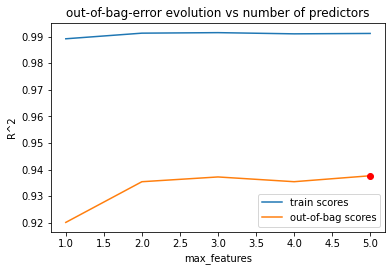

In [29]:
if 1 == 0:  # Skip it, this cell is used only to obtain the optimum value of max_features through Out-of-Bag error
    
    # Validation using Out-of-Bag error
    # ==============================================================================
    import math

    train_scores = []
    oob_scores   = []
    iter_x_train = x_train_pca
    iter_y_train = y_train_pca

    # Evaluated values
    max_features_range = range(1, 2*math.ceil(iter_x_train.shape[1]/2), 1)

    # Loop to train a model with each max_features value and obtain its training and
    # Out-of-Bag error.
    for max_features in max_features_range:
        RFmodel = RandomForestRegressor(
                    n_estimators = 25,
                    criterion    = 'mse',
                    max_depth    = None,
                    max_features = max_features,
                    oob_score    = True,
                    n_jobs       = -1,
                    random_state = 123
                 )
        RFmodel.fit(iter_x_train, iter_y_train)
        train_scores.append(RFmodel.score(iter_x_train, iter_y_train))
        oob_scores.append(RFmodel.oob_score_)

    # Graph with the error trend
    fig, ax = plt.subplots(figsize=(6, 3.84))
    ax.plot(max_features_range, train_scores, label="train scores")
    ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
    ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
            marker='o', color = "red")
    ax.set_ylabel("R^2")
    ax.set_xlabel("max_features")
    ax.set_title("out-of-bag-error evolution vs number of predictors")
    plt.legend();
    print(f"optimum value of max_features: {max_features_range[np.argmax(oob_scores)]}")

In [ ]:
results

In [ ]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )